In [1]:
import sys
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Documents/GitHub/Gaze_project')
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evansamaa/Documents/GitHub/Gaze_project")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/EvansToolBox/Utils")
sys.path.insert(0, "C:/Users/evan1/Documents/GitHub/Gaze_project")
from InputStructures import *
from EyeCatch_implementation import *
from Ground_truth_implementation import *
import json
import numpy as np
import pickle
import os
import pandas as pd

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def output_motion(hk, ek, micro_saccade, outpath, delay=0.0):
    blend_weight = []
    for i in range(1, len(hk[0])-1):
        velocity = math.sqrt((hk[0][i][1]-hk[0][i-1][1])**2 + (hk[0][i-1][2]-hk[0][i][2])**2)
        blend_weight.append([hk[0][i][0], 1 - min(1, velocity/0.75)])
    for i in range(0, len(ek[0])):
        ek[0][i][0] -= delay
    for i in range(0, len(hk[0])):
        hk[0][i][0] -= delay
    out = {"eye_frames": ek,
            "head_frames": hk,
            "micro_saccade": micro_saccade,
            "other_neck": [],
            "envelope":[], 
            "ambient_neck":[]}
            # "output_times": output_times, 
            # "output_targets": output_targets
    with open(outpath, 'wb') as f:
        pickle.dump(out, f, protocol=2)
    print(outpath)

In [6]:
import imageio
import numpy as np
from PIL import Image, ImageDraw

def generate_video_multiple_example_concentric_circles(time_arr, angle_arr_1_list, angle_arr_2_list, radius_list, image_size, output_filename='animation.mp4'):
    frames = []
    # any one of them could be the time array
    for i in range(len(time_arr)):
        # set the image to be black        
        img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        img[:, :] = [0, 0, 0]  # Fill the image with black initially
        # Create an image object using PIL
        pil_img = Image.fromarray(img)

        # Calculate the center of the image
        center_x = image_size // 2
        center_y = image_size // 2
        for j in range(len(angle_arr_1_list)):
            angle_arr_1 = angle_arr_1_list[j] - 90
            angle_arr_2 = angle_arr_2_list[j] - 90
            radius = radius_list[j]
            angle_1 = angle_arr_1[i]
            angle_2 = angle_arr_2[i]

            # Calculate the bounding box for the ellipse based on the center and radius
            ellipse_bbox = [
                (center_x - radius, center_y - radius),
                (center_x + radius - 1, center_y + radius - 1)
            ]

            # Draw the circle outline at the center
            draw = ImageDraw.Draw(pil_img)
            draw.ellipse(ellipse_bbox, outline=(255, 255, 255), width=2)  # White outline

            # Calculate circle positions
            circle_radius = radius // 9  # 1/7th of the larger circle radius

            circle_x_1 = center_x + int(radius * np.cos(np.radians(angle_1)))
            circle_y_1 = center_y + int(radius * np.sin(np.radians(angle_1)))

            circle_x_2 = center_x + int(radius * np.cos(np.radians(angle_2)))
            circle_y_2 = center_y + int(radius * np.sin(np.radians(angle_2)))

            # Calculate orientation for the equilateral triangle based on angle
            # Ensures the triangle always faces away from the center of the circle
            angle_orientation = np.radians(angle_1)  # Add 180 degrees to face away from the center

            triangle_points = [
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation)), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation))  # Top vertex
                ),
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation - (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation - (2 * np.pi / 3)))  # Bottom left vertex
                ),
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation + (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation + (2 * np.pi / 3)))  # Bottom right vertex
                )
            ]

            # Draw an equilateral triangle (green)
            draw_triangle = ImageDraw.Draw(pil_img)
            draw_triangle.polygon(triangle_points, fill=(0, 255, 0))  # Green equilateral triangle

            draw_2 = ImageDraw.Draw(pil_img)
            draw_2.ellipse([(circle_x_2 - circle_radius // 2, circle_y_2 - circle_radius // 2), (circle_x_2 + circle_radius // 2 - 1, circle_y_2 + circle_radius // 2 - 1)], fill=(255, 0, 0))  # Red circle

        frames.append(np.array(pil_img))

    # Save frames as a video
    with imageio.get_writer(output_filename, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)

# Process gaze arr for input gaze:

In [7]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

def get_gaze_inputs_naive(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    # gaze_fixations_angles = gaze_fixations[:, 1]
    # gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_sequence = []
    for i in range(0, len(gaze_fixations)):
        input_sequence.append([ts[gaze_fixations_intervals[i][0]], gaze_fixations[i, 0]])
    input_sequence = np.array(input_sequence).T
    return input_sequence

def get_gaze_inputs(eye_traj, head_traj, input_times, input_angles):
    gaze_traj = eye_traj[:, 1:] + head_traj[:, 1:]
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(eye_traj[:, 0], gaze_traj[:, 1:], 3, duraiton_threshold=0.05)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]
    # time arr
    ts = eye_traj[:, 0]
    ts = ts - ts[0]
    input_intervals = []
    for i in range(0, len(input_times)-1):
        input_intervals.append([input_times[i], input_times[i+1]])
    input_intervals.append([input_times[-1], input_times[-1]+100])
    # for each intervals of input
    
    for i in range(0, len(input_intervals)):
        # iterate through each gaze interval and find the first time stamp that is within 5 degrees of the input angle
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(gaze_fixations_intervals[j])
        interval_to_look = [gaze_fixations_index_in_interval[0][0], gaze_fixations_index_in_interval[-1][1]]
        starting_index = -1
        for j in range(interval_to_look[0], interval_to_look[1]):
            if abs(gaze_traj[j, 1] - input_angles[i]) < 1:
                starting_index = j
                break    
        if starting_index == -1:
            for j in range(interval_to_look[0], interval_to_look[1]):
                if abs(gaze_traj[j, 1] - input_angles[i]) < 5:
                    starting_index = j
                    break
        print(interval_to_look, starting_index)
        # plot the trajectory and the starting point
        # plt.plot(ts[interval_to_look[0]:interval_to_look[1]], gaze_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[interval_to_look[0]:interval_to_look[1]], head_traj[interval_to_look[0]:interval_to_look[1], 1])
        plt.plot(ts[starting_index], head_traj[starting_index, 1], 'r*')
        plt.show()
        
            

    
    for i in range(0, len(input_intervals)):
        continue
        # find the gaze fixations that are in the interval
        gaze_fixations_index_in_interval = []
        for j in range(0, len(gaze_fixations_intervals)):
            # it just have to start within the interval
            if ts[gaze_fixations_intervals[j][0]] >= input_intervals[i][0] and ts[gaze_fixations_intervals[j][0]] <= input_intervals[i][1]:
                gaze_fixations_index_in_interval.append(j)
        # this is the interval of interest
        interval_of_interest = [gaze_fixations_intervals[gaze_fixations_index_in_interval[0]][0], gaze_fixations_intervals[gaze_fixations_index_in_interval[-1]][1]]
        fixations_angles_in_interval = gaze_fixations[gaze_fixations_index_in_interval, 0]
        # find the first angle within 5 degrees of the input angle in this interval
        index_of_first_angle_within_5_degrees = -1
        for j in range(0, len(fixations_angles_in_interval)):
            if abs(fixations_angles_in_interval[j] - input_angles[i]) < 5:
                index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                break
        if index_of_first_angle_within_5_degrees == -1:
            for j in range(0, len(fixations_angles_in_interval)):
                if abs(fixations_angles_in_interval[j] - input_angles[i]) < 10:
                    index_of_first_angle_within_5_degrees = gaze_fixations_index_in_interval[j]
                    break
        print(input_angles[i])
        # plot the gaze trajectory
        plt.plot(ts[interval_of_interest[0]:interval_of_interest[1]], gaze_traj[interval_of_interest[0]:interval_of_interest[1], 1])
        # plot the gaze fixations from the first point to the point that is within 5 degrees of the input angle till the end of the gaze fixations
        plt.plot(ts[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1]], gaze_traj[gaze_fixations_intervals[index_of_first_angle_within_5_degrees][0]:gaze_fixations_intervals[index_of_first_angle_within_5_degrees][1], 1], 'r')
        plt.show()

# List of Inputs and Scenes

In [8]:
class InternalModelFromCapture:
    def __init__(self, input_json, gaze_arr = None):
        # input json is generated from the quest pro capture from experimentation/Analyze_trajectory_research_paper.py\
        self.input_json = input_json
        self.gaze_arr = gaze_arr
    def estimate_target_pose(self, index):
        if self.gaze_arr is not None:
            angle = self.gaze_arr[index]
        else:
            angle = self.input_json["input_target_angle"][index]
        pos = directions_from_rotation_angles(np.array([[angle, 0]]), 100)[0]
        return pos
    def get_base_pose(self):
        return np.array([0, 0, 100])

In [9]:
drive = "F:/"
# drive = "E:/"
# drive = "/Volumes/EVAN_DISK/"
input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_onward_condition_pilot.json"])))
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_random_condition.json"])))
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_1_double_look_condition_pilot.json"])))
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_1_tennis_condition_pilot.json"])))
print(input_json_0.keys())

internal_model_0 = InternalModelFromCapture(input_json_0)
sequence_0 = []
for i in range(0, len(input_json_0["input_target_angle"])):
    sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])

dict_keys(['head_trajectory', 'eye_trajectory', 'target_trajectory', 'input_target_times', 'input_target_angle'])


In [13]:
print(input_json_0["eye_trajectory"])

[[86.25163, 6.15628, 3.679232, 0.6587048], [86.26378, 6.184537, 3.699903, 0.6482381], [86.27711, 4.991448, 4.041351, 0.6545546], [86.29094, 5.011644, 4.057677, 0.651945], [86.30411, 5.082672, 4.234654, 0.6679164], [86.31856, 5.085704, 4.243892, 0.6660907], [86.33233, 5.134738, 4.521091, 0.6839955], [86.3456, 5.13603, 4.520554, 0.6697655], [86.36085, 5.142917, 4.515412, 0.6574715], [86.37421, 5.119821, 4.488561, 0.6430421], [86.3881, 5.127813, 4.478162, 0.6369424], [86.40127, 4.887559, 3.79033, 0.5845302], [86.4162, 4.914, 3.772699, 0.5802504], [86.42996, 4.953166, 3.753266, 0.5695845], [86.443, 5.027065, 3.734147, 0.5425686], [86.4575, 5.075139, 3.703359, 0.5199293], [86.47155, 5.192763, 3.709341, 0.5002376], [86.4845, 5.242701, 3.660265, 0.4831088], [86.49921, 5.963898, 3.756393, 0.4863722], [86.51327, 6.045386, 3.669869, 0.450011], [86.52779, 6.142169, 3.574173, 0.4055177], [86.54047, 6.384823, 3.804426, 0.3937473], [86.55493, 6.467376, 3.705056, 0.3719662], [86.56915, 6.619672, 3.78

# Select the Deesired set of inputs

In [35]:
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "/Users/evanpan/Documents/GitHub/EyeIK/animation_data"
OUTPUT_VIDEO_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/output_video_data"
model_name_pairs = [["GT", "Proposed_graph"], ["GT", "Itti"]]
radius_pairs = [[200, 160], [200, 160]]
input_json = input_json_0
sequence = sequence_0
input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)
gaze_positions = []
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(internal_model.estimate_target_pose(i))


# Visualizing the output arrays in Maya

In [36]:
plot_ending = 5000

In [37]:
def compare_kf_plot_hk(ek1, ek2, hk1, hk2, name1="GT", name2="Proposed", end = None):
    # index 0 = time
    # index 1 = sideways
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if end is not None:
        hk1 = hk1[:end]
    # plt.plot(ek2[:, 0], ek2[:, 1], 'r')
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0] - 0.1
        # find the largest time stamp in hk2 that is less than the final time stamp in hk1
        hk2_interp = interp1d(hk2[:, 0], hk2[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
        hk2_val = hk2_interp(hk1[:, 0])
    else:
        hk2 = hk2[:end]
    plt.plot(hk1[:, 0], hk2_val, 'b', label=name2)
    plt.plot(hk1[:, 0], hk1[:, 1], 'g', label=name1)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Neck angle (deg)")

    plt.show()  
def compare_kf_plot_ek(ek1, ek2, hk1, hk2, name1="GT", name2="Proposed", end = None):
    ek1 = np.array(ek1)[0]
    ek2 = np.array(ek2)[0]
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if end is not None:
        hk1 = hk1[:end]
        hk2 = hk2[:end]
        ek1 = ek1[:end]
        ek2 = ek2[:end]
    ek_angles1 = rotation_angles_frome_positions(ek1[:, 1:])
    ek_angles2 = rotation_angles_frome_positions(ek2[:, 1:])
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0] - 0.1
        ek_angles2_interp = interp1d(ek2[:, 0], ek_angles2[:, 0], axis=0, fill_value="extrapolate", bounds_error=False)
        ek_angles2_val = ek_angles2_interp(hk1[:, 0])
    plt.plot(hk1[:, 0], ek_angles1[:, 0] + hk1[:, 1], 'g', label=name1)
    plt.plot(hk1[:, 0], ek_angles2_val, 'b', label=name2)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Eye angle (deg)")
    plt.show()  
    
def compare_kf_error_hk(ek1, ek2, hk1, hk2, name1="GT"):
    hk1 = np.array(hk1)[0]
    hk2 = np.array(hk2)[0]
    if name1 == "GT":
        hk1[:, 0] = hk1[:, 0]
    # resample the second one to be the same length as the first
    hk2_interp = interp1d(hk2[:, 0], hk2[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
    re_factor_hk2 = 1.0 * hk2_interp(hk1[:, 0])
    mse = np.mean((hk1[:, 1] - re_factor_hk2)**2)
    return mse

yeet
C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\GT.pkl


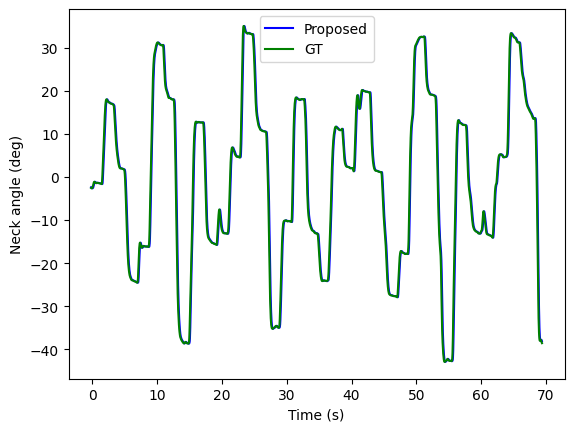

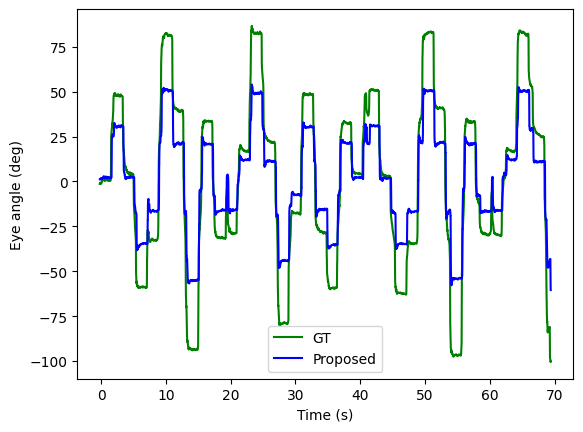

In [38]:
from Ground_truth_implementation import *

saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT.pkl"), delay=0.1)
gt_hk_angles = np.array(gt_hk[0])[:, 1]
gt_hk_times = np.array(gt_hk[0])[:, 0]
gt_hk_angles_interp = interp1d(gt_hk_times, gt_hk_angles, axis=0, fill_value="extrapolate")
gt_gaze_angles = rotation_angles_frome_positions(np.array(gt_ek[0])[:, 1:])
gt_gaze_angles = np.array(gt_gaze_angles)[:, 0] + gt_hk_angles
gt_ek_angles_interp = interp1d(gt_hk_times, gt_gaze_angles, axis=0, fill_value="extrapolate")
compare_kf_plot_hk(gt_ek, gt_ek, gt_hk, gt_hk, end=plot_ending)
compare_kf_plot_ek(gt_ek, gt_ek, gt_hk, gt_hk, end=plot_ending)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Yeo.pkl
Yeo error 18.929696343997282


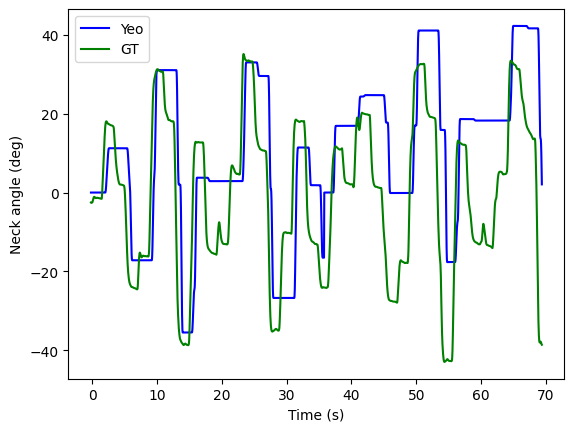

In [39]:
from EyeCatch_implementation import *
# get target positions from the scene:
saccade_generator = EyeCatch_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Yeo.pkl"))
print("Yeo error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Yeo", end=plot_ending)

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Oyekoya.pkl
Oyekoya error 19.859022750507233


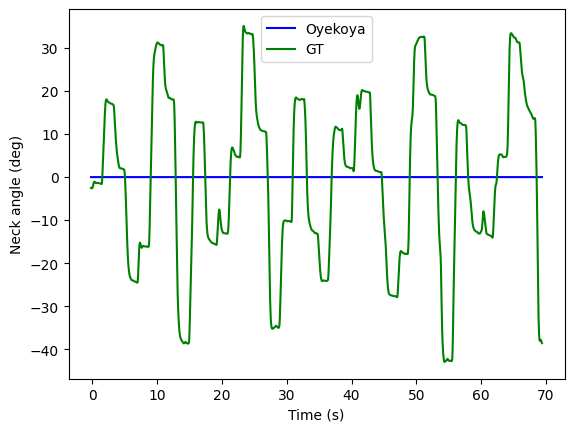

In [40]:

from Oyekoya_implementation import *
# get target positions from the scene:
saccade_generator = Oyekoya_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()    
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Oyekoya.pkl"))
print("Oyekoya error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Oyekoya", end=plot_ending)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Andrist.pkl
Andrist error 14.527977340359104


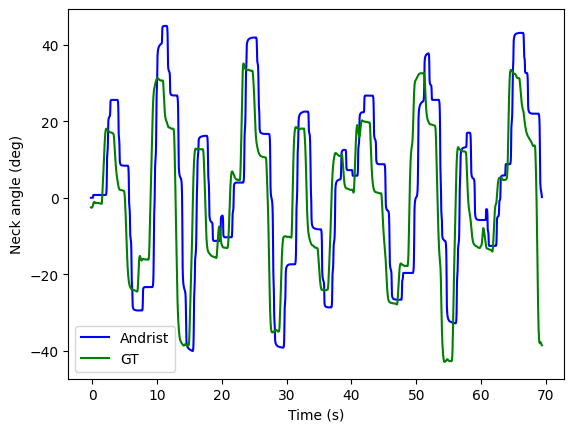

In [41]:
from Andrist_implementation import *
# get target positions from the scene:
saccade_generator = Andrist_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
ek, hk, micro_saccade = saccade_generator.compute()    
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Andrist.pkl"))
print("Andrist error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Andrist", end=plot_ending)

C:\Users/evansamaa/Documents/GitHub/EvansToolBox/Utils\Geometry_Util.py:47: RuntimeWarning: invalid value encountered in divide
  out = arr / mag


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Goude.pkl
Goude error 34.67772979464039


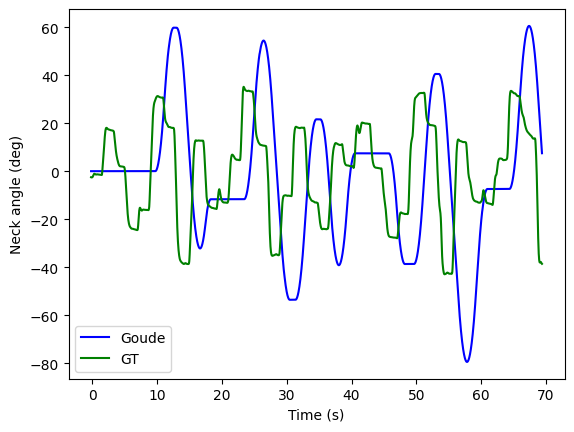

In [42]:
from Goude_implementation import *
# get target positions from the scene:

saccade_generator = Goude_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Goude.pkl"))
print("Goude error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Goude", end=plot_ending)

c:\Users\evansamaa\anaconda3\envs\JaliGaze\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Jin.pkl
Jin error 16.065334669098196


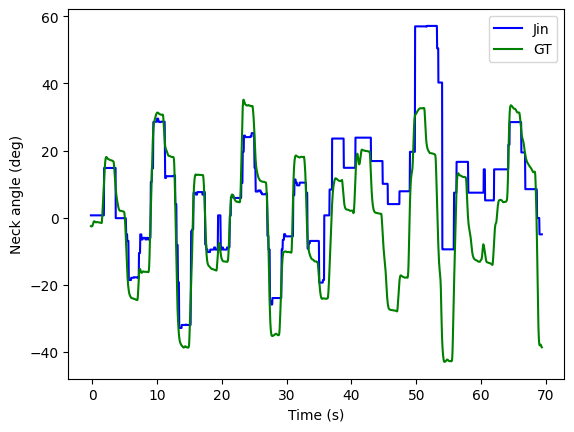

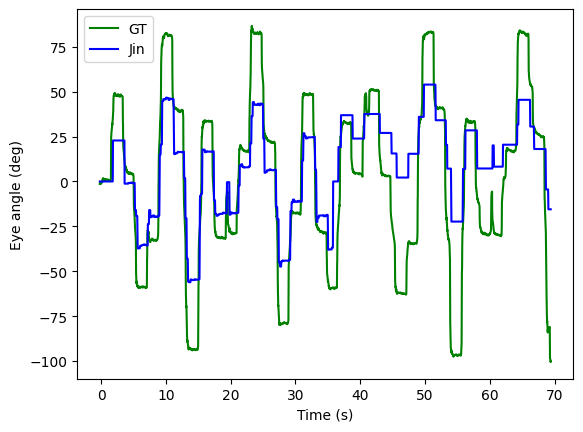

In [43]:

from Jin_implementation import *
# get target positions from the scene:
# saccade_generator = Jin_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
saccade_generator = Jin_SacccadeGenerator(np.array(gt_ek)[0, :, 0], np.array(gt_ek)[0, :, 1:], np.arange(0, np.array(gt_ek).shape[1]), internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, gt_ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Jin.pkl"))
print("Jin error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Jin", end=plot_ending)
compare_kf_plot_ek(gt_ek, ek, gt_hk, hk, name2="Jin", end=plot_ending)


c:\Users\evansamaa\Documents\GitHub\EyeIK\Itti_implementation.py:111: RuntimeWarning: invalid value encountered in divide
  v = v / np.sum(v)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Itti.pkl
Itti error 11.439289062957972


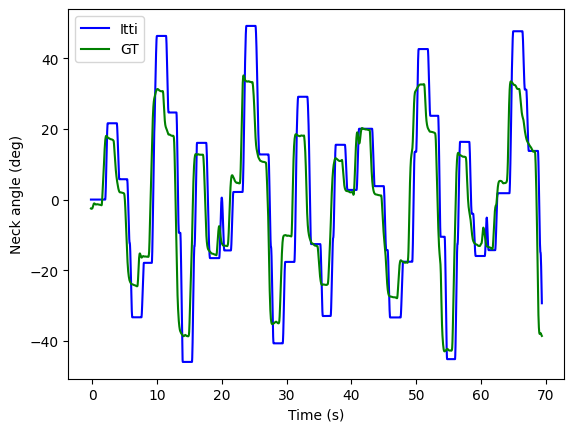

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [44]:

from Itti_implementation import *
# get target positions from the scene:
saccade_generator = Itti_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Itti.pkl"))
print("Itti error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Itti", end=plot_ending)
generate_video_multiple_example_concentric_circles(np.array(gt_ek)[0][:, 0], [np.array(gt_hk[0])[:, 1]], [np.array(gt_ek[0])[:, 1]], [100], 500, output_filename=os.path.join(OUTPUT_VIDEO_ROOT, "Itti.mp4"))

C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Pejsa.pkl
Pejsa error 12.208198622302067


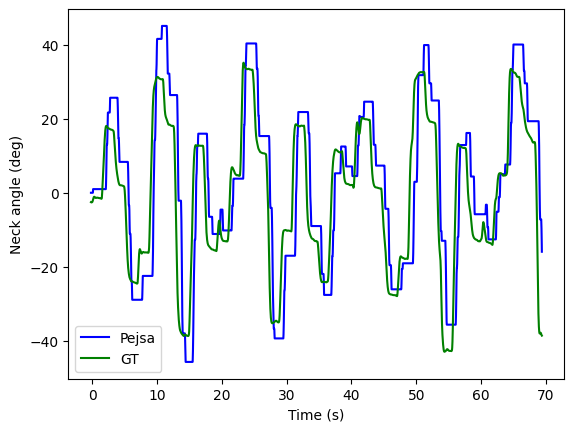

In [45]:

from Pejsa_implementation import *
# get target positions from the scene:
saccade_generator = Pejsa_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Pejsa.pkl"))
print("Pejsa error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, name2="Pejsa", end=plot_ending)

C:\Users/evansamaa/Documents/GitHub/EvansToolBox/Utils\Geometry_Util.py:123: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot_product)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Proposed.pkl
Proposed error 14.022897915617326


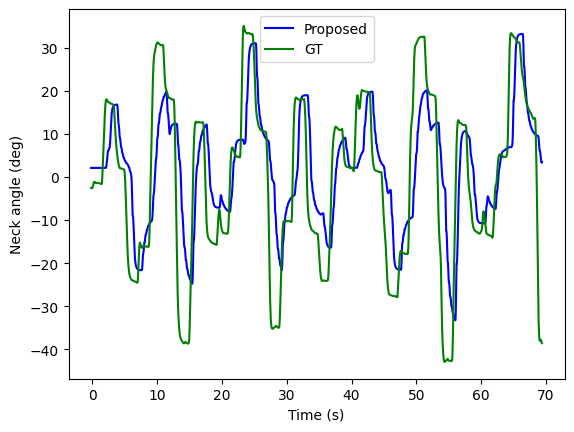

In [46]:
from Proposed_model import *
# get target positions from the scene:
saccade_generator = Proposed_saccade_generator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
ek, hk, micro_saccade = saccade_generator.compute()
output_motion(hk, ek, micro_saccade, os.path.join(OUTPUT_ROOT, "Proposed.pkl"))
print("Proposed error", np.sqrt(compare_kf_error_hk(gt_ek, ek, gt_hk, hk, name1="GT")))
compare_kf_plot_hk(gt_ek, ek, gt_hk, hk, end=plot_ending)


C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data\Proposed_graph1.pkl
Proposed error 10.985419036544355


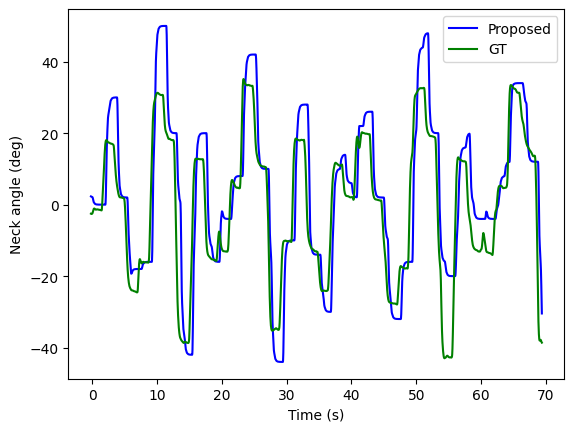

In [47]:
import networkx as nx
from Proposed_model import *
def dwell_factored_eye_strain_function(dwell_time, angle_j, angle0, angle1):
    # vanilla
    # dwell_time_factor1 = dwell_time
    # dwell_time_factor0 = np.maximum(1.5 - dwell_time, 0)
    # probably better?
    dwell_time_factor1 = np.maximum(0.0001, 1 - np.exp(-0.8*dwell_time)) # this is higher for shorter dwell times)
    dwell_time_factor0 = np.exp(-0.8*dwell_time) # this is higher for longer dwell times
    return dwell_time_factor0 * np.linalg.norm(angle_j - angle1) + dwell_time_factor1 * np.linalg.norm(angle_j - angle0) + 0.4 *np.abs(angle_j)
def head_moving_cost_function(prev, current, dwell_time, laziness=0.6):
    # cost is the distance the the head has to move
    cost = laziness * np.linalg.norm(prev - current)
    if np.linalg.norm(prev - current) <= 4:
        cost = 0
    # but this cost is lowered in the direction of the midline
    # return np.maximum(0.0001, 1.5-np.log(dwell_time + 1)) * cost
    return np.exp(-0.8*dwell_time) * cost
def create_graph(self, laziness=0.5):
    gaze_trajectory_1 = self.input_gaze_pos_as_angles_per_frame
    gaze_trajectory_0 = self.input_gaze_pos_as_angles_per_frame_smoothed
    gaze_positions = self.gaze_pos_as_angles
    gaze_intervals = self.target_gaze_intervals_time
    graphs = []
    for dimension in range(0, 2):
        if dimension == 0:
            range_limit = 60
        else:
            range_limit = 30
        G = nx.DiGraph()
        list_plot = []
        for i in range(0, gaze_positions.shape[0]):
            t_index = int(np.ceil(gaze_intervals[i][0]/self.simulation_dt))
            t_index = min(t_index, gaze_trajectory_0.shape[0]-1)
            target_angle_0 = gaze_trajectory_0[t_index, dimension]
            target_angle_1 = gaze_trajectory_1[t_index, dimension]
            list_plot.append(target_angle_1)
            dwell_time = gaze_intervals[i][1] - gaze_intervals[i][0]
            for j in range(-range_limit, range_limit, 2):
                G.add_node((i, j), value=dwell_factored_eye_strain_function(dwell_time, j, target_angle_0, target_angle_1))
                if i > 0:
                    for j_prev in range(-range_limit, range_limit, 2):
                        G.add_edge((i-1, j_prev), (i, j), weight=head_moving_cost_function(j_prev, j, dwell_time, laziness=laziness))
        G.add_node((gaze_positions.shape[0], int(gaze_positions[-1][dimension])), value=0)
        for j_prev in range(-range_limit, range_limit, 2):
            G.add_edge((gaze_positions.shape[0]-1, j_prev), (gaze_positions.shape[0], int(gaze_positions[-1][dimension])), weight=head_moving_cost_function(j_prev, j, dwell_time))
        graphs.append(G)
    return graphs
def optimize_head_pos(self, laziness=0.54):
    G_0, G_1 = create_graph(self, laziness)
    def combined_weight0(u, v, d):
        return G_0.nodes[v]['value'] + d['weight']
    def combined_weight1(u, v, d):
        return G_1.nodes[v]['value'] + d['weight']
    path_0 = nx.dijkstra_path(G_0, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][0])), combined_weight0)
    path_0 = np.array(path_0)[:, 1:2]
    path_1 = nx.dijkstra_path(G_1, (0, 0), (saccade_generator.gaze_pos_as_angles.shape[0], int(self.gaze_pos_as_angles[-1][1])), combined_weight1)
    path_1 = np.array(path_1)[:, 1:2]
    head_angles = np.concatenate([path_0, path_1], axis=1)
    head_pos = directions_from_rotation_angles(head_angles, 100)
    return head_angles, head_pos 

saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model, reach_target_at_times=False, head_delay=0)

ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(optimize_head_pos(saccade_generator)[1])
output_motion(hk_proposed, ek_propsed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_graph1.pkl"))
print("Proposed error", np.sqrt(compare_kf_error_hk(gt_ek, ek_propsed, gt_hk, hk_proposed, name1="GT")))
compare_kf_plot_hk(gt_ek, ek_propsed, gt_hk, hk_proposed, name2="Proposed", end=plot_ending)

# Quantitatively Compare the MSE of all models

In [2]:
from sklearn.metrics import mean_squared_error
import pandas as pd

drive = "F:/"
drive = "/Volumes/EVAN_DISK/"
participant_number = ["1", "2", "0"]
experiment_names = ["double_look_condition_pilot", "onward_condition_pilot", "random_condition", "tennis_condition_pilot"]
# experiment_names = ["double_look_condition_pilot"]
file_name_template = "MASC/EYE_IK/ground_truth/Experiment_{}_{}.json"
# OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"
OUTPUT_ROOT = "./animation_data"

# load all the files and compute the error
for mmm in range (len(participant_number)):
    error_dict = {}
    for nnn in range (len(experiment_names)):
        # laod inputs
        input_json_0 = json.load(open(os.path.join(*[drive, file_name_template.format(participant_number[mmm], experiment_names[nnn])])))
        internal_model_0 = InternalModelFromCapture(input_json_0)
        sequence_0 = []
        for i in range(0, len(input_json_0["input_target_angle"])):
            sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
        input_json = input_json_0
        sequence = sequence_0
        input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
        internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
        for i in range(0, input_sequence.shape[1]):
            input_sequence[1][i] = int(i)
        gaze_positions = []
        for i in range(0, input_sequence.shape[1]):
            gaze_positions.append(internal_model.estimate_target_pose(i))
            
        # get ground_truth head_keyframes:
        saccade_generator = Ground_truth_SacccadeGenerator(input_json=input_json)
        gt_ek, gt_hk, gt_micro_saccade = saccade_generator.compute()
        output_motion(gt_hk, gt_ek, gt_micro_saccade, os.path.join(OUTPUT_ROOT, "GT_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get eye_catch head_keyframes:
        saccade_generator = EyeCatch_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_eye_catch, hk_eye_catch, micro_saccade_eye_catch = saccade_generator.compute()
        output_motion(hk_eye_catch, ek_eye_catch, micro_saccade_eye_catch, os.path.join(OUTPUT_ROOT, "EyeCatch_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get oyekoya head_keyframes:
        saccade_generator = Oyekoya_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_oyekoya, hk_oyekoya, micro_saccade_oyekoya = saccade_generator.compute()
        output_motion(hk_oyekoya, ek_oyekoya, micro_saccade_oyekoya, os.path.join(OUTPUT_ROOT, "Oyekoya_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get andrist head_keyframes:
        saccade_generator = Andrist_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
        ek_andrist, hk_andrist, micro_saccade_andrist = saccade_generator.compute()
        output_motion(hk_andrist, ek_andrist, micro_saccade_andrist, os.path.join(OUTPUT_ROOT, "Andrist_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get goude head_keyframes:
        saccade_generator = Goude_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_goude, hk_goude, micro_saccade_goude = saccade_generator.compute()
        output_motion(hk_goude, ek_goude, micro_saccade_goude, os.path.join(OUTPUT_ROOT, "Goude_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get jin head_keyframes:
        saccade_generator = Jin_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, root_dir="../")
        ek_jin, hk_jin, micro_saccade_jin = saccade_generator.compute()
        output_motion(hk_jin, ek_jin, micro_saccade_jin, os.path.join(OUTPUT_ROOT, "Jin_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get itti head_keyframes:
        saccade_generator = Itti_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_itti, hk_itti, micro_saccade_itti = saccade_generator.compute()
        output_motion(hk_itti, ek_itti, micro_saccade_itti, os.path.join(OUTPUT_ROOT, "Itti_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get pejsa head_keyframes:
        saccade_generator = Pejsa_SacccadeGenerator(input_sequence[0], gaze_positions, input_sequence[1], internal_model, 0.5)
        ek_pejsa, hk_pejsa, micro_saccade_pejsa = saccade_generator.compute()
        output_motion(hk_pejsa, ek_pejsa, micro_saccade_pejsa, os.path.join(OUTPUT_ROOT, "Pejsa_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get proposed graph head_keyframes:
        saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_proposed_graph, hk_proposed_graph, micro_saccade_proposed_graph = saccade_generator.compute(optimize_head_pos(saccade_generator)[1])
        output_motion(hk_proposed_graph, ek_proposed_graph, micro_saccade_proposed_graph, os.path.join(OUTPUT_ROOT, "Proposed_graph_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        # get proposed head_keyframes:
        saccade_generator = Proposed_saccade_generator(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_proposed, hk_proposed, micro_saccade_proposed = saccade_generator.compute()
        output_motion(hk_proposed, ek_proposed, micro_saccade_proposed, os.path.join(OUTPUT_ROOT, "Proposed_{}_{}.pkl".format(participant_number[mmm], experiment_names[nnn])))
        
        # for each model, compute the error and save it in error_dict
        error_dict["participant_{}_".format(participant_number[mmm]) 
                + experiment_names[nnn]] = {}
        error_dict["participant_{}_".format(participant_number[mmm]) 
                + experiment_names[nnn]]["GT"] = compare_kf_error_hk(gt_ek, gt_ek, gt_hk, gt_hk)
        error_dict["participant_{}_".format(participant_number[mmm])
                    + experiment_names[nnn]]["EyeCatch"] = compare_kf_error_hk(gt_ek, ek_eye_catch, gt_hk, hk_eye_catch)
        error_dict["participant_{}_".format(participant_number[mmm])
                    + experiment_names[nnn]]["Oyekoya"] = compare_kf_error_hk(gt_ek, ek_oyekoya, gt_hk, hk_oyekoya)
        error_dict["participant_{}_".format(participant_number[mmm])
                    + experiment_names[nnn]]["Andrist"] = compare_kf_error_hk(gt_ek, ek_andrist, gt_hk, hk_andrist)
        error_dict["participant_{}_".format(participant_number[mmm])
                    + experiment_names[nnn]]["Goude"] = compare_kf_error_hk(gt_ek, ek_goude, gt_hk, hk_goude)
        error_dict["participant_{}_".format(participant_number[mmm])
                
                    + experiment_names[nnn]]["Jin"] = compare_kf_error_hk(gt_ek, ek_jin, gt_hk, hk_jin)
        error_dict["participant_{}_".format(participant_number[mmm])
                    + experiment_names[nnn]]["Itti"] = compare_kf_error_hk(gt_ek, ek_itti, gt_hk, hk_itti)
        error_dict["participant_{}_".format(participant_number[mmm])
                        + experiment_names[nnn]]["Pejsa"] = compare_kf_error_hk(gt_ek, ek_pejsa, gt_hk, hk_pejsa)
        error_dict["participant_{}_".format(participant_number[mmm])
                        + experiment_names[nnn]]["Proposed"] = compare_kf_error_hk(gt_ek, ek_proposed, gt_hk, hk_proposed)
        error_dict["participant_{}_".format(participant_number[mmm])
                            + experiment_names[nnn]]["Proposed_graph"] = compare_kf_error_hk(gt_ek, ek_proposed_graph, gt_hk, hk_proposed_graph)
        # save error_dict
        with open(os.path.join(OUTPUT_ROOT, "error_dict_{}.json".format(participant_number[mmm])), 'w') as f:
            json.dump(error_dict, f)


NameError: name 'json' is not defined

In [3]:
drive = "F:/"
dribe = "/Volumes/EVAN_DISK/"
participant_number = ["1", "2", "0"]
experiment_names = ["double_look_condition_pilot", "onward_condition_pilot", "random_condition", "tennis_condition_pilot"]
# experiment_names = ["onward_condition_pilot"]
file_name_template = "MASC/EYE_IK/ground_truth/Experiment_{}_{}.json"
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
OUTPUT_ROOT = "/Users/evanpan/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"
# print out the error for all the models for all trials

mean_error_double_look = {}
mean_error_onward = {}
mean_error_random = {}
mean_error_tennis = {}
compute_mean_error = True

for mmm in range (len(participant_number)):
    # load the error dict
    error_dict = json.load(open(os.path.join(OUTPUT_ROOT, "error_dict_{}.json".format(participant_number[mmm]))))
    for nnn in range (len(experiment_names)):
        print("participant_{}_".format(participant_number[mmm]) + experiment_names[nnn])
        # print("GT", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["GT"])
        print("EyeCatch", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["EyeCatch"])
        print("Oyekoya", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Oyekoya"])
        print("Andrist", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Andrist"])
        print("Goude", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Goude"])
        print("Jin", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Jin"])
        print("Itti", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Itti"])
        print("Pejsa", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Pejsa"])
        # print("Proposed", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Proposed"])
        print("Proposed_graph", error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Proposed_graph"])
        # get the mean error for each condition
        if compute_mean_error:
            condition_to_dict_dict = {"double_look_condition_pilot": mean_error_double_look, "onward_condition_pilot": mean_error_onward, "random_condition": mean_error_random, "tennis_condition_pilot": mean_error_tennis}
            dicts_thing = condition_to_dict_dict[experiment_names[nnn]]
            try:
                dicts_thing["EyeCatch"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["EyeCatch"])
            except:
                dicts_thing["EyeCatch"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["EyeCatch"]]
            try:
                dicts_thing["Oyekoya"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Oyekoya"])
            except:
                dicts_thing["Oyekoya"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Oyekoya"]]
            try:
                dicts_thing["Andrist"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Andrist"])
            except:
                dicts_thing["Andrist"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Andrist"]]
            try:
                dicts_thing["Goude"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Goude"])
            except:
                dicts_thing["Goude"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Goude"]]
            try:
                dicts_thing["Jin"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Jin"])
            except:
                dicts_thing["Jin"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Jin"]]
            try:
                dicts_thing["Itti"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Itti"])
            except:
                dicts_thing["Itti"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Itti"]]
            try:
                dicts_thing["Pejsa"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Pejsa"])
            except:
                dicts_thing["Pejsa"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Pejsa"]]
            try:
                dicts_thing["Proposed_graph"].append(error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Proposed_graph"])
            except:
                dicts_thing["Proposed_graph"] = [error_dict["participant_{}_".format(participant_number[mmm]) + experiment_names[nnn]]["Proposed_graph"]]

# print out the mean error for each condition
if compute_mean_error:
    print("mean_error_double_look")
    for key in mean_error_double_look.keys():
        print(key, np.mean(np.sqrt(mean_error_double_look[key])))
    print("mean_error_onward")
    for key in mean_error_onward.keys():
        print(key, np.mean(np.sqrt(mean_error_onward[key])))
    print("mean_error_random")
    for key in mean_error_random.keys():
        print(key, np.mean(np.sqrt(mean_error_random[key])))
    print("mean_error_tennis")
    for key in mean_error_tennis.keys():
        print(key, np.mean(np.sqrt(mean_error_tennis[key])))


NameError: name 'json' is not defined

# Conduct Parameter Search

In [15]:
from itertools import product
def hyperparameter_search(get_optimizer, hyperparameters):
    """
    Perform a hyperparameter search using grid search.

    Parameters:
    model (object): A machine learning model object with a .fit method.
    hyperparameters (dict): A dictionary of hyperparameters to search over.
    X (array-like): The input data for the model.
    y (array-like): The target data for the model.

    Returns:
    best_params (dict): The best hyperparameters found.
    """
    # Get all combinations of hyperparameters
    all_params = product(*hyperparameters.values())

    # Initialize variables to keep track of best model performance
    best_score = float('-inf')
    best_params = None
    values = []
    # Loop over all hyperparameter combinations
    rt_params = []
    for params in all_params:
        # Set hyperparameters for the model
        # print(params)
        model_i = get_optimizer(params)
        saccade_generator = Proposed_saccade_generator_with_graph(input_sequence[0], gaze_positions, input_sequence[1], internal_model)
        ek_propsed, hk_proposed, micro_saccade_proposed = saccade_generator.compute(model_i(saccade_generator)[1])
        # Calculate model performance using cross-validation
        mean_score = compare_kf_error_hk(gt_ek, ek_propsed, gt_hk, hk_proposed)
        compare_kf_plot_hk(gt_ek, ek_propsed, gt_hk, hk_proposed)
        # Update best score and parameters if current score is better
        if mean_score < best_score:
            best_score = mean_score
            best_params = params
        values.append(mean_score)
        rt_params.append([params[0], mean_score])
        print(rt_params[-1])
    print(best_params, best_score)
    return best_params, rt_params

In [16]:
hyperparameters = {
    'laziness': [0.01, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0],
}
def get_optimizer(weights):
    def optimizer(saccade_generator):
        return optimize_head_pos(saccade_generator, laziness=weights[0])
    return optimizer
    
__, output = hyperparameter_search(get_optimizer, hyperparameters)
    

NameError: name 'Proposed_saccade_generator_with_graph' is not defined

# justify the laplacian is good for showing anticipation

In [ ]:
drive = "F:/"
# drive = "E:/"
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_onward_condition_pilot.json"])))
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_random_condition.json"])))
input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_1_tennis_condition_pilot.json"])))
print(input_json_0.keys())

internal_model_0 = InternalModelFromCapture(input_json_0)
sequence_0 = []
for i in range(0, len(input_json_0["input_target_angle"])):
    sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])
# Select the Deesired set of inputs
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"

input_json = input_json_0
sequence = sequence_0
input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)
gaze_positions = []
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(internal_model.estimate_target_pose(i))


dict_keys(['head_trajectory', 'eye_trajectory', 'target_trajectory', 'input_target_times', 'input_target_angle'])


# Alternative Visualization - Circle

In [ ]:
# write a function that reads the output of output_motion, and return hk, ek and micro_saccade
def read_output_motion(file_name):
    output = pickle.load(open(file_name, 'rb'))
    hk = output["head_frames"]
    ek = output["eye_frames"]
    micro_saccade = output["micro_saccade"]
    return hk, ek, micro_saccade

In [ ]:
import imageio
import numpy as np
from PIL import Image, ImageDraw

def generate_video_single_example(time_arr, angle_arr_1, angle_arr_2, radius, image_size, output_filename='animation.mp4'):
    frames = []
    for i in range(len(time_arr)):
        angle_1 = angle_arr_1[i]
        angle_2 = angle_arr_2[i]

        img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        img[:, :] = [0, 0, 0]  # Fill the image with black initially

        # Create an image object using PIL
        pil_img = Image.fromarray(img)

        # Calculate the center of the image
        center_x = image_size // 2
        center_y = image_size // 2

        # Calculate the bounding box for the ellipse based on the center and radius
        ellipse_bbox = [
            (center_x - radius, center_y - radius),
            (center_x + radius - 1, center_y + radius - 1)
        ]

        # Draw the circle outline at the center
        draw = ImageDraw.Draw(pil_img)
        draw.ellipse(ellipse_bbox, outline=(255, 255, 255), width=2)  # White outline

        # Calculate circle positions
        circle_radius = radius // 9  # 1/7th of the larger circle radius

        circle_x_1 = center_x + int(radius * np.cos(np.radians(angle_1)))
        circle_y_1 = center_y + int(radius * np.sin(np.radians(angle_1)))

        circle_x_2 = center_x + int(radius * np.cos(np.radians(angle_2)))
        circle_y_2 = center_y + int(radius * np.sin(np.radians(angle_2)))

        # Calculate triangle points for the equilateral triangle
        triangle_height = circle_radius * np.sqrt(3) / 2
        triangle_base = circle_radius

        # Calculate orientation for the equilateral triangle based on angle
        # Ensures the triangle always faces away from the center of the circle
        angle_orientation = np.radians(angle_1)  # Add 180 degrees to face away from the center

        triangle_points = [
            (
                circle_x_1 + int(circle_radius * np.cos(angle_orientation)), 
                circle_y_1 + int(circle_radius * np.sin(angle_orientation))  # Top vertex
            ),
            (
                circle_x_1 + int(circle_radius * np.cos(angle_orientation - (2 * np.pi / 3))), 
                circle_y_1 + int(circle_radius * np.sin(angle_orientation - (2 * np.pi / 3)))  # Bottom left vertex
            ),
            (
                circle_x_1 + int(circle_radius * np.cos(angle_orientation + (2 * np.pi / 3))), 
                circle_y_1 + int(circle_radius * np.sin(angle_orientation + (2 * np.pi / 3)))  # Bottom right vertex
            )
        ]

        # Draw an equilateral triangle (green)
        draw_triangle = ImageDraw.Draw(pil_img)
        draw_triangle.polygon(triangle_points, fill=(0, 255, 0))  # Green equilateral triangle


        draw_2 = ImageDraw.Draw(pil_img)
        draw_2.ellipse([(circle_x_2 - circle_radius, circle_y_2 - circle_radius), (circle_x_2 + circle_radius - 1, circle_y_2 + circle_radius - 1)], fill=(255, 0, 0))  # Red circle

        frames.append(np.array(pil_img))

    # Save frames as a video
    with imageio.get_writer(output_filename, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)

# Example usage:
time_arr = np.linspace(0, 10, 100)  # Example time array
angle_arr_1 = np.linspace(0, -90, 100)  # Example angle array 1
angle_arr_2 = np.linspace(0, 90, 100)  # Example angle array 2
radius = 200  # Example radius
image_size = 800  # Example image size

generate_video_single_example(time_arr, angle_arr_1, angle_arr_2, radius, image_size)


In [ ]:
drive = "F:/"
participant_number = ["1", "2", "0"]
experiment_names = ["double_look_condition_pilot", "onward_condition_pilot", "random_condition"]
file_name_template = "MASC/EYE_IK/ground_truth/Experiment_{}_{}.json"
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"

# load the generated output_data
mmm = 0
nnn = 0

model_names = ["GT", "EyeCatch", "Oyekoya", "Andrist", "Goude", "Jin", "Itti", "Pejsa", "Proposed_graph"]

# first try and get the ts for all the models
max_time = 0
for model_name in model_names:
    hk, ek, micro_saccade = read_output_motion(os.path.join(OUTPUT_ROOT, "{}_{}_{}.pkl".format(model_name, participant_number[mmm], experiment_names[nnn])))
    max_time = max(max_time, hk[0][-1][0])
ts = np.arange(0, max_time, 1/30)    


for model_name in model_names:  
    hk, ek, micro_saccade = read_output_motion(os.path.join(OUTPUT_ROOT, "{}_{}_{}.pkl".format(model_name, participant_number[mmm], experiment_names[nnn])))
    hk = np.array(hk)[0]
    ek = np.array(ek)[0]
    ek_angles = rotation_angles_frome_positions(ek[:, 1:])
    # micro_saccade = np.array(micro_saccade)[0]
    hk_interp = interp1d(hk[:, 0], hk[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
    ek_angles_interp = interp1d(hk[:, 0], ek_angles[:, 0], axis=0, fill_value="extrapolate", bounds_error=False)
    
    hk_resampled = hk_interp(ts)
    ek_angles_resampled = ek_angles_interp(ts)
    if model_name == "GT":
        ek_angles_resampled += hk_resampled
    generate_video_single_example(ts, hk_resampled, ek_angles_resampled, radius, image_size)
    break

# Alternative Visualization - Concentric Circle

In [62]:
import imageio
import numpy as np
from PIL import Image, ImageDraw

def generate_video_multiple_example_concentric_circles(time_arr, angle_arr_1_list, angle_arr_2_list, radius_list, image_size, output_filename='animation.mp4'):
    frames = []
    # any one of them could be the time array
    for i in range(len(time_arr)):
        # set the image to be black        
        img = np.zeros((image_size, image_size, 3), dtype=np.uint8)
        img[:, :] = [0, 0, 0]  # Fill the image with black initially
        # Create an image object using PIL
        pil_img = Image.fromarray(img)

        # Calculate the center of the image
        center_x = image_size // 2
        center_y = image_size // 2
        for j in range(len(angle_arr_1_list)):
            angle_arr_1 = angle_arr_1_list[j] - 90
            angle_arr_2 = angle_arr_2_list[j] - 90
            radius = radius_list[j]
            angle_1 = angle_arr_1[i]
            angle_2 = angle_arr_2[i]

            # Calculate the bounding box for the ellipse based on the center and radius
            ellipse_bbox = [
                (center_x - radius, center_y - radius),
                (center_x + radius - 1, center_y + radius - 1)
            ]

            # Draw the circle outline at the center
            draw = ImageDraw.Draw(pil_img)
            draw.ellipse(ellipse_bbox, outline=(255, 255, 255), width=2)  # White outline

            # Calculate circle positions
            circle_radius = radius // 9  # 1/7th of the larger circle radius

            circle_x_1 = center_x + int(radius * np.cos(np.radians(angle_1)))
            circle_y_1 = center_y + int(radius * np.sin(np.radians(angle_1)))

            circle_x_2 = center_x + int(radius * np.cos(np.radians(angle_2)))
            circle_y_2 = center_y + int(radius * np.sin(np.radians(angle_2)))

            # Calculate orientation for the equilateral triangle based on angle
            # Ensures the triangle always faces away from the center of the circle
            angle_orientation = np.radians(angle_1)  # Add 180 degrees to face away from the center

            triangle_points = [
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation)), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation))  # Top vertex
                ),
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation - (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation - (2 * np.pi / 3)))  # Bottom left vertex
                ),
                (
                    circle_x_1 + int(circle_radius * np.cos(angle_orientation + (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius * np.sin(angle_orientation + (2 * np.pi / 3)))  # Bottom right vertex
                )
            ]

            # Draw an equilateral triangle (green)
            draw_triangle = ImageDraw.Draw(pil_img)
            draw_triangle.polygon(triangle_points, fill=(0, 255, 0))  # Green equilateral triangle

            draw_2 = ImageDraw.Draw(pil_img)
            draw_2.ellipse([(circle_x_2 - circle_radius // 2, circle_y_2 - circle_radius // 2), (circle_x_2 + circle_radius // 2 - 1, circle_y_2 + circle_radius // 2 - 1)], fill=(255, 0, 0))  # Red circle

        frames.append(np.array(pil_img))

    # Save frames as a video
    with imageio.get_writer(output_filename, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)

In [ ]:
drive = "F:/"
participant_number = ["1", "2", "0"]
experiment_names = ["double_look_condition_pilot", "onward_condition_pilot", "random_condition"]
file_name_template = "MASC/EYE_IK/ground_truth/Experiment_{}_{}.json"
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
model_names = ["GT", "EyeCatch", "Oyekoya", "Andrist", "Goude", "Jin", "Itti", "Pejsa", "Proposed_graph"]

# load the generated output_data
mmm = 0
nnn = 0


model_name_pairs = [["GT", "Proposed_graph"], ["GT", "Itti"]]
radius_pairs = [[200, 160], [200, 160]]
# first try and get the ts for all the models
max_time = 0
for model_name in model_names:
    hk, ek, micro_saccade = read_output_motion(os.path.join(OUTPUT_ROOT, "{}_{}_{}.pkl".format(model_name, participant_number[mmm], experiment_names[nnn])))
    max_time = max(max_time, hk[0][-1][0])
ts = np.arange(0, max_time, 1/30)  


for i in range(len(model_name_pairs)):
    model_name_pair = model_name_pairs[i]
    radius = radius_pairs[i]
    hk_list = []
    ek_list = []
    for model_name in model_name_pair:
        hk, ek, micro_saccade = read_output_motion(os.path.join(OUTPUT_ROOT, "{}_{}_{}.pkl".format(model_name, participant_number[mmm], experiment_names[nnn])))
        hk = np.array(hk)[0]
        ek = np.array(ek)[0]
        ek_angles = rotation_angles_frome_positions(ek[:, 1:])
        # micro_saccade = np.array(micro_saccade)[0]
        hk_interp = interp1d(hk[:, 0], hk[:, 1], axis=0, fill_value="extrapolate", bounds_error=False)
        ek_angles_interp = interp1d(hk[:, 0], ek_angles[:, 0], axis=0, fill_value="extrapolate", bounds_error=False)    
        hk_resampled = hk_interp(ts)
        ek_angles_resampled = ek_angles_interp(ts)
        if model_name == "GT":
            hk_resampled = hk_interp(ts - 0.1)
            ek_angles_resampled = ek_angles_interp(ts - 0.1)
            ek_angles_resampled += hk_resampled
        hk_list.append(hk_resampled)
        ek_list.append(ek_angles_resampled)
    
    generate_video_multiple_example_concentric_circles(ts, hk_list, ek_list, radius, image_size, output_filename=os.path.join(OUTPUT_ROOT, "comparison_{}_{}_{}.mp4".format(model_name_pair[0], model_name_pair[1], participant_number[mmm])))
    # break

In [ ]:
drive = "F:/"
# drive = "E:/"
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_onward_condition_pilot.json"])))
# input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_2_random_condition.json"])))
input_json_0 = json.load(open(os.path.join(*[drive, "MASC/EYE_IK/ground_truth/Experiment_1_double_look_condition_pilot.json"])))
print(input_json_0.keys())

internal_model_0 = InternalModelFromCapture(input_json_0)
sequence_0 = []
for i in range(0, len(input_json_0["input_target_angle"])):
    sequence_0.append([input_json_0["input_target_times"][i], input_json_0["input_target_angle"][i]])

dict_keys(['head_trajectory', 'eye_trajectory', 'target_trajectory', 'input_target_times', 'input_target_angle'])


# Select the Deesired set of inputs

In [ ]:
OUTPUT_ROOT = "C:/Users/evansamaa/Documents/GitHub/EyeIK/animation_data"
# OUTPUT_ROOT = "C:/Users/evan1/OneDrive/Documents/GitHub/EyeIK/animation_data"

input_json = input_json_0
sequence = sequence_0
input_sequence = get_gaze_inputs_naive(np.array(input_json["eye_trajectory"]), np.array(input_json["head_trajectory"]), input_json["input_target_times"], input_json["input_target_angle"])
internal_model = InternalModelFromCapture(input_json, gaze_arr = input_sequence[1].copy())
for i in range(0, input_sequence.shape[1]):
    input_sequence[1][i] = int(i)
gaze_positions = []
for i in range(0, input_sequence.shape[1]):
    gaze_positions.append(internal_model.estimate_target_pose(i))


In [ ]:
import imageio
import numpy as np
from PIL import Image, ImageDraw

def generate_video(time_arr_list, angle_arr_1_list, angle_arr_2_list, radius_list, image_size, output_filename='animation.mp4'):
    frames = []
    max_len = len(time_arr_list[0])
    
    for i in range(max_len):
        time_arr = time_arr_list[i % len(time_arr_list)]
        angle_arr_1 = angle_arr_1_list[i % len(angle_arr_1_list)]
        angle_arr_2 = angle_arr_2_list[i % len(angle_arr_2_list)]
        radius = radius_list[i % len(radius_list)]



        # Create an image object using PIL
        pil_img = Image.fromarray(img)

        # Calculate the center of the image
        center_x = image_size // 2
        center_y = image_size // 2

        # Draw concentric circles
        for j in range(len(radius)):
            circle_radius = radius[j]
            
            # Calculate the bounding box for the circle outline based on the center and radius
            ellipse_bbox = [
                (center_x - circle_radius, center_y - circle_radius),
                (center_x + circle_radius - 1, center_y + circle_radius - 1)
            ]

            # Draw the circle outline at the center
            draw = ImageDraw.Draw(pil_img)
            draw.ellipse(ellipse_bbox, outline=(255, 255, 255))  # White outline

            # Calculate circle positions
            circle_x_1 = center_x + int(circle_radius * np.cos(np.radians(angle_arr_1[i])))
            circle_y_1 = center_y + int(circle_radius * np.sin(np.radians(angle_arr_1[i])))

            circle_x_2 = center_x + int(circle_radius * np.cos(np.radians(angle_arr_2[i])))
            circle_y_2 = center_y + int(circle_radius * np.sin(np.radians(angle_arr_2[i])))

            # Draw smaller circles or triangles at the calculated positions
            circle_radius_small = circle_radius // 7  # 1/7th of the larger circle radius

            # Draw a smaller circle (red circle)
            draw_circle = ImageDraw.Draw(pil_img)
            draw_circle.ellipse([(circle_x_2 - circle_radius_small, circle_y_2 - circle_radius_small), 
                                 (circle_x_2 + circle_radius_small - 1, circle_y_2 + circle_radius_small - 1)], fill=(255, 0, 0))  # Red circle

            # Draw an equilateral triangle (green) oriented away from the center
            angle_orientation = np.radians(angle_arr_1[i] + 180)  # Add 180 degrees to face away from the center
            triangle_points = [
                (
                    circle_x_1 + int(circle_radius_small * np.cos(angle_orientation)), 
                    circle_y_1 + int(circle_radius_small * np.sin(angle_orientation))  # Top vertex
                ),
                (
                    circle_x_1 + int(circle_radius_small * np.cos(angle_orientation - (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius_small * np.sin(angle_orientation - (2 * np.pi / 3)))  # Bottom left vertex
                ),
                (
                    circle_x_1 + int(circle_radius_small * np.cos(angle_orientation + (2 * np.pi / 3))), 
                    circle_y_1 + int(circle_radius_small * np.sin(angle_orientation + (2 * np.pi / 3)))  # Bottom right vertex
                )
            ]

            # Draw the equilateral triangle
            draw_triangle = ImageDraw.Draw(pil_img)
            draw_triangle.polygon(triangle_points, fill=(0, 255, 0))  # Green equilateral triangle

        frames.append(np.array(pil_img))

    # Save frames as a video
    with imageio.get_writer(output_filename, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)

# Example usage:
time_arr_list = [np.linspace(0, 10, 100), np.linspace(0, 5, 50)]  # Example list of time arrays
angle_arr_1_list = [np.linspace(0, 360, 100), np.linspace(90, -270, 50)]  # Example list of angle arrays 1
angle_arr_2_list = [np.linspace(90, -270, 100), np.linspace(0, 360, 50)]  # Example list of angle arrays 2
radius_list = [[50, 75, 100], [50, 100, 150]]  # Example list of radius lists
image_size = 400  # Example image size

generate_video(time_arr_list, angle_arr_1_list, angle_arr_2_list, radius_list, image_size)
